In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ssm.util import random_rotation
from ssm import LDS
import ssm

In [3]:
# Set the parameters of the HMM
T = 1000   # number of time bins
D_latent = 2      # number of latent dimensions
D_obs = 10     # number of observed dimensions
K = 4
# Make an LDS with somewhat interesting dynamics parameters
#true_lds = LDS(N, D, emissions="gaussian")

In [4]:
def make_nascar_model():
    As = [random_rotation(D_latent, np.pi/24.),
      random_rotation(D_latent, np.pi/48.)]

    # Set the center points for each system
    centers = [np.array([+2.0, 0.]),
           np.array([-2.0, 0.])]
    bs = [-(A - np.eye(D_latent)).dot(center) for A, center in zip(As, centers)]

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([+0.1, 0.]))

    # Add a "right" state
    As.append(np.eye(D_latent))
    bs.append(np.array([-0.25, 0.]))

    # Construct multinomial regression to divvy up the space
    w1, b1 = np.array([+1.0, 0.0]), np.array([-2.0])   # x + b > 0 -> x > -b
    w2, b2 = np.array([-1.0, 0.0]), np.array([-2.0])   # -x + b > 0 -> x < b
    w3, b3 = np.array([0.0, +1.0]), np.array([0.0])    # y > 0
    w4, b4 = np.array([0.0, -1.0]), np.array([0.0])    # y < 0
    Rs = np.row_stack((100*w1, 100*w2, 10*w3,10*w4))
    r = np.concatenate((100*b1, 100*b2, 10*b3, 10*b4))

    true_rslds = ssm.SLDS(D_obs, K, D_latent,
                      transitions="recurrent_only",
                      dynamics="diagonal_gaussian",
                      emissions="gaussian_orthog",
                      single_subspace=True)
    true_rslds.dynamics.mu_init = np.tile(np.array([[0, 1]]), (K, 1))
    true_rslds.dynamics.sigmasq_init = 1e-4 * np.ones((K, D_latent))
    true_rslds.dynamics.As = np.array(As)
    true_rslds.dynamics.bs = np.array(bs)
    true_rslds.dynamics.sigmasq = 1e-4 * np.ones((K, D_latent))

    true_rslds.transitions.Rs = Rs
    true_rslds.transitions.r = r

    true_rslds.emissions.inv_etas = np.log(1e-2) * np.ones((1, D_obs))
    return true_rslds

In [5]:
### Make a Nascar model ### 
true_rslds = make_nascar_model()

In [6]:
### Sample from it ####
z, x, y = true_rslds.sample(1000)

In [7]:
#### Initialize a new model ### 
rslds = ssm.SLDS(D_obs, K, D_latent,
                      transitions="recurrent_only",
                      dynamics="diagonal_gaussian",
                      emissions="gaussian_orthog",
                      single_subspace=True)
rslds.initialize(y)
_, post = rslds.fit(y, 
                   method="laplace_em",
                    variational_posterior="structured_meanfield",
                    num_iters=100, alpha=0.0, 
                   initialize=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
tmp = post.discrete_expectations
Ez, Ezzp1, _ = tmp[0]
x = post.mean_continuous_states[0]

### True data -- use to estimate log_prob; 
log_prob = rslds._laplace_neg_expected_log_joint(y,
                                     np.zeros((T, 0)),
                                     np.ones_like(y), 
                                     None, 
                                     x,
                                     Ez,
                                     Ezzp1)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

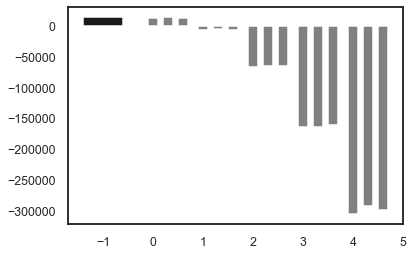

In [10]:
f,ax = plt.subplots()
ax.bar(-1, -1*log_prob, color='k')
T = 1000;

### See how noisy data looks -- ideally should get lower log-probs with more noise ;
for noise in range(5): 
    for i in range(3):
        
        _, _, y = true_rslds.sample(T)
        y = y + noise*.2*np.random.randn(*y.shape)
        _, post = rslds.approximate_posterior(y, num_iters=100, alpha=0.0)
        tmp = post.discrete_expectations
        Ez, Ezzp1, _ = tmp[0]
        x = post.mean_continuous_states[0]

        ### negative expected log something (lower seems better)
        log_prob_i = rslds._laplace_neg_expected_log_joint(y,
                                         np.zeros((T, 0)),
                                         np.ones_like(y), 
                                         None, 
                                         x,
                                         Ez,
                                         Ezzp1)
        ### postive expected log something (higher is better)
        ax.bar(noise + (i*.3), -1*log_prob_i, width = .2, color='gray')